<a href="https://colab.research.google.com/github/CarlosfcPinheiro/pibic-api-llm-integration/blob/main/pibic_teste_aplicacao_rest_sync.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teste de requisições para LLM utilizando padrão REST síncrono
O objetivo principal é testar e avaliar o tempo de resposta de requisições para uma API que interaja com LLMs, utilizando o padrão REST sícrono.

## Código e estrutura
Para análise, são utilizados **8 prompts diferentes**, que buscam explorar diferentes tamanhos e temáticas de texto. São feitos **30 requisições para a API**, onde são armazenado os tempos de resposta de todas as requests para cada prompt, respectivamente.

Após as requisições serem feitas, os tempos de requisição são armazenados em um csv, que é lido posteriormente para compor os dados de análise, que também são escritos em um outro csv.

Além disso, cada conjunto de testes são executados utilizando **4 modelos diferentes**, que fundamentalmente são especializados em sumarização, mas com objetivos diferentes. Os modelos utilizados são:

- facebook/bart_large_cnn
- google/pegasus_cnn_dailymail
- knkarthick/MEETING_SUMMARY
- google/pegasus_xsum

## Padrões e bibliotecas
O padrão a ser utilizado é o **REST síncrono**, dado que aplica os princípios e restrições para criação de  sistemas distribuídos e escaláveis através de ações bloqueantes.

As principais bibliotecas utilizadas são:
- time (funções de manipulação de tempo)
- requests (envio de requisições HTTP)
- csv (manipulação de arquivos csv)
- statistics (funções para cálculos estatísticos)
- numpy (funções para manipulação de arrays e matrizes)

## Métricas analisadas
As métricas utilizadas para análise do tempo de resposta da requisição para cada prompt foram as seguintes:
- Média de tempo (tempo médio de resposta das requisições)
- Máximo e Mínimo (tempo com valores máximos e mínimos)
- Desvio padrão (dispersão absoluta dos dados em relação à média, numericamente)
- Coeficiente de variação (dispersão relativa dos dados em relação à média, em  porcentagem)
- Percentil - 95% e 99% (valores abaixo do qual uma certa porcentagem dos tempos se encontram)

> Todas as métricas levam em consideração a unidade de segundos para o tempo de resposta da requisição

In [ ]:
# Definição dos prompts e endpoint =======================
API_URL = "https://zetta-faunlike-kindheartedly.ngrok-free.dev"
# modelo utilizado para as requisições
MODEL = "facebook_bart_large_cnn"
ENDPOINT_TEST = f"{API_URL}/summarize?model={MODEL}"

PROMPTS = [
    """Solar energy is one of the most promising renewable sources for the planet’s future. With concerns about climate change and the need to reduce fossil fuel dependence, many countries are investing in clean technologies. Brazil has one of the largest solar potentials, especially in the Northeast and Midwest, where radiation is high year-round. The installation of solar panels in homes and businesses has grown, driven by incentives and lower equipment costs. Distributed generation allows consumers to also produce energy, helping decentralize the electricity system. Challenges remain, such as infrastructure, storage, and stronger public policies, but with technology and social engagement, solar energy is set to play an increasingly important role in Brazil’s energy matrix.""",

    """The city of Ouro Preto, located in the state of Minas Gerais, is one of the greatest symbols of Brazilian colonial architecture and history. Founded in the 17th century during the gold rush, it quickly became one of the main economic centers of the Portuguese colony, attracting thousands of people in search of wealth. Its stone streets, steep slopes, and preserved buildings reveal a past marked by opulence, religiosity, and resistance. Ouro Preto is home to some of the most impressive baroque churches in Brazil, such as the Church of Saint Francis of Assisi, designed by Aleijadinho and decorated with works by Mestre Ataíde. The city was also the stage for important events of the Inconfidência Mineira, a movement that sought Brazil’s independence from Portugal. Today, the city is recognized as a UNESCO World Heritage Site, attracting tourists interested in history, art, and culture. In addition to its historical value, Ouro Preto has a vibrant university life thanks to the Federal University of Ouro Preto (UFOP) and hosts various festivals of art, music, and cinema throughout the year. This combination of tradition and youth makes the city a unique place where past and present coexist in harmony.""",

    """Artificial intelligence (AI) is one of the most transformative technologies of the 21st century. It impacts medicine, education, industry, and commerce, improving efficiency and user experience. At the same time, AI raises ethical concerns about data use, bias, and its impact on jobs. Governments and society must ensure its benefits are distributed fairly and responsibly.""",

    """Classical music, although it emerged centuries ago, continues to influence contemporary composers. Works by Beethoven, Mozart, and Bach are studied in conservatories and reinterpreted in different musical styles. This tradition shows how art can transcend generations and reinvent itself.""",

    """The history of the internet began in the 1960s with military projects in the United States, evolving into academic networks and later into commercial use. Today, the internet connects billions of people in real time, transforming the way we work, study, and interact. Digital platforms enable instant communication, e-commerce, and unlimited access to information. However, problems also arise, such as fake news, cybercrime, and technological dependence. The future of the internet depends on balanced regulations, continuous innovation, and digital education so that its benefits can be enjoyed safely and inclusively.""",

    """Coffee is one of the most consumed beverages in the world and is part of Brazilian culture.""",

    """The Olympic Games are more than just a sporting event; they represent a celebration of unity, diversity, and human achievement. Athletes from around the world gather to compete at the highest level, showcasing not only physical skill but also resilience and determination. The Games have evolved over time, incorporating new disciplines and promoting values such as fair play and respect. Beyond the competitions, the Olympics foster cultural exchange, allowing nations to share traditions and build mutual understanding. Despite challenges such as political tensions and financial costs, the spirit of the Olympics continues to inspire millions, proving that sport can be a powerful force for peace and cooperation.""",

    """The Renaissance was a period of profound cultural, artistic, and scientific transformation in Europe between the 14th and 17th centuries. It marked the rediscovery of classical knowledge and the flourishing of human creativity. Artists like Leonardo da Vinci and Michelangelo produced masterpieces that continue to inspire admiration today, while scientists such as Galileo challenged traditional views of the universe. The invention of the printing press by Gutenberg revolutionized the spread of ideas, making books more accessible and fueling intellectual debates."""
]


In [ ]:
# Fazendo requisições e armazenando tempo de resposta ===============
import requests
import time
import csv
# cada prompt é testado e armazenado em um .csv contendo as colunas de: prompt de entrada, resposta de saída, tamanho do prompt e tempo de execução

# Para esse modelo a RESPOSTA DE SAÍDA é indiferente, pois possui parâmetros padrões determinísticos, evitando variações criativas
# cada prompt deve fazer 30 requisições

# Tem problema os prompts resultarem na mesma saída, dado uma mesma entrada? (justificativa do modelo). Seria importante que o modelopossua variações criativas?

CSV_REQ_TIMES = f"./tempos/tempo_requisicoes_{MODEL}.csv"
REQS_PER_PROMPT = 30

OPERATION_TIME = 0

# Adicionar try catch aqui para resposta com exceção
with open(CSV_REQ_TIMES, mode="w", newline="", encoding="utf-8") as file:
  writer = csv.writer(file)
  writer.writerow([
      "prompt_id",
      "req_id",
      "prompt_entrada",
      "saída_resposta",
      "tamanho_prompt",
      "tamanho_saida",
      "tempo_s"
  ])

  for pid, prompt in enumerate(PROMPTS, start=1):
    for req_id in range(1, REQS_PER_PROMPT+1):
      try:
        start_req = time.time()
        response = requests.post(ENDPOINT_TEST, json={"text":prompt})
        end_req = time.time()

        # devo armazenar a resposta ??
        text_response = response.json()
        total_time = round(end_req - start_req, 4)

        OPERATION_TIME += total_time

        writer.writerow([
            pid,
            req_id,
            prompt,
            text_response["summary"],
            len(prompt),
            len(text_response["summary"]),
            total_time
        ])
      except Exception as e:
          print(f"Houve um problema com o teste das requisições, prompt/{pid} req/{req_id}:\n {e}")
          break
    print(f"Tempos de resposta do prompt {pid} registrado.")

print("\nDados de tempo de resposta escritos com sucesso.")
print(f"Tempo total da operação: {round(OPERATION_TIME, 4)}s")

Tempos de resposta do prompt 1 registrado.
Tempos de resposta do prompt 2 registrado.
Tempos de resposta do prompt 3 registrado.
Tempos de resposta do prompt 4 registrado.
Tempos de resposta do prompt 5 registrado.
Tempos de resposta do prompt 6 registrado.
Tempos de resposta do prompt 7 registrado.
Tempos de resposta do prompt 8 registrado.

Dados de tempo de resposta escritos com sucesso.
Tempo total da operação: 1014.199s


In [ ]:
# Fazendo análise e registrando dados ==========================
import statistics
import numpy as np
import csv

CSV_RAW = f"./tempos/tempo_requisicoes_{MODEL}.csv"
CSV_REQ_TIMES_METRICS = f"./metricas/metricas_tempo_requisicoes_{MODEL}.csv"

# dicionário com o array de todos os tempos de requisição
TIMES_REQ_PER_PROMPT_ALL = {}

# armazenar pid, time e prompt_size no dicionário através do csv já existente
with open(CSV_RAW, mode="r", newline="", encoding="utf-8") as file:
  reader = csv.DictReader(file)
  for row in reader:
    pid = int(row["prompt_id"])
    time = float(row["tempo_s"])
    prompt_size = int(row["tamanho_prompt"])

    if pid not in TIMES_REQ_PER_PROMPT_ALL:
      TIMES_REQ_PER_PROMPT_ALL[pid] = {"tempos": [], "tamanho_prompt": prompt_size}
    # Não seria possível armazenar o array de uma vez no dicionário
    TIMES_REQ_PER_PROMPT_ALL[pid]["tempos"].append(time)

# criação do csv as métricas de cada prompt
with open(CSV_REQ_TIMES_METRICS, mode="w", newline="", encoding="utf-8") as  file:
  writer = csv.writer(file)
  writer.writerow([
      "prompt_id",
      "tamanho_prompt",
      "tempo_req_min_s",
      "tempo_req_max_s",
      "tempo_total_s",
      "req_por_prompt",
      "media_tempo_s",
      "desvio_padrao_s",
      "coef_var_%",
      "p95_s",
      "p99_s"
  ])

  for pid, data in TIMES_REQ_PER_PROMPT_ALL.items():
    times = data["tempos"]

    prompt_size = data["tamanho_prompt"]
    min_time = min(times)
    max_time = max(times)
    total_time= round(sum(times), 4)
    req_per_prompt = len(times)
    avg = round(statistics.mean(times), 4)
    std = round(statistics.pstdev(times), 4) # pst x std ???
    coef_var = round(std/avg, 4)
    p95 = round(float(np.percentile(times, 95)), 4)
    p99 = round(float(np.percentile(times, 99)), 4)

    writer.writerow([
        pid,
        prompt_size,
        min_time,
        max_time,
        total_time,
        req_per_prompt,
        avg,
        std,
        coef_var,
        p95,
        p99
    ])

print("Análise e cálculo de métricas finalizado")

Análise e cálculo de métricas finalizado


In [ ]:
from google.colab import data_table
import pandas as pd

data_table.enable_dataframe_formatter()
df = pd.read_csv(f"./metricas/metricas_tempo_requisicoes_{MODEL}.csv")

print("\nMétricas de cada requisição:")
display(df)


Métricas de cada requisição:


,prompt_id,tamanho_prompt,tempo_req_min_s,tempo_req_max_s,tempo_total_s,req_por_prompt,media_tempo_s,desvio_padrao_s,coef_var_%,p95_s,p99_s
0,1,779,2.6386,9.6648,108.7852,30,3.6262,1.5758,0.4346,6.7890,9.3297
1,2,1214,2.5182,5.1730,102.4249,30,3.4142,0.6401,0.1875,4.7626,5.1106
2,3,374,1.6711,79.7683,262.8877,30,8.7629,17.3391,1.9787,43.9891,72.9124
3,4,288,2.1197,50.6604,219.8302,30,7.3277,11.8298,1.6144,37.5707,47.3698
4,5,620,1.7574,29.8095,103.5558,30,3.4519,5.0346,1.4585,6.5703,23.5376
5,6,91,1.5143,9.9646,69.2819,30,2.3094,1.4849,0.6430,3.2334,8.1473
6,7,716,1.7229,5.3166,75.7039,30,2.5235,0.6516,0.2582,3.1520,4.7154
7,8,567,1.5537,13.3193,71.7294,30,2.3910,2.0561,0.8599,2.6044,10.2125


In [3]:
# Juntando o csv de output de métricas de cada modelo ========================
import pandas as pd
import glob
import os

path = "./metricas"
all_files = glob.glob(os.path.join(path, "*.csv"))
print(all_files, type(all_files[0]))

dfs = []
for file in all_files:
  df = pd.read_csv(file)
  model_name = os.path.splitext(os.path.basename(file))[0].replace("metricas_tempo_requisicoes_", "")

  df["modelo"] = model_name
  dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)
final_df.to_csv("metricas_modelos_geral.csv", index=False)
print(".csv de métricas dos modelos armazenadas em csv")

['./metricas/metricas_tempo_requisicoes_facebook_bart_large_cnn.csv', './metricas/metricas_tempo_requisicoes_knkarthick_MEETING_SUMMARY.csv', './metricas/metricas_tempo_requisicoes_google_pegasus_xsum.csv', './metricas/metricas_tempo_requisicoes_google_pegasus-cnn_dailymail.csv'] <class 'str'>
.csv de métricas dos modelos armazenadas em csv


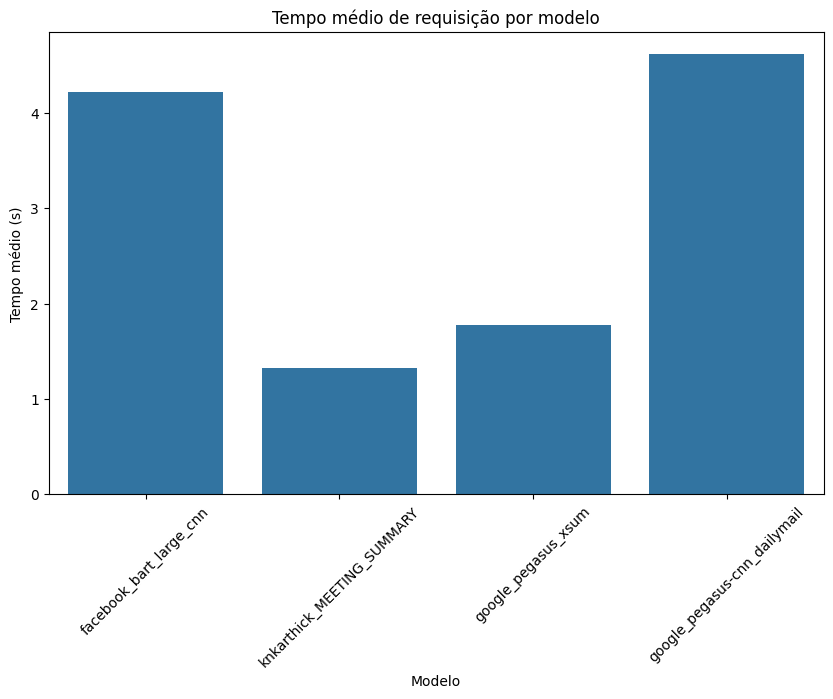

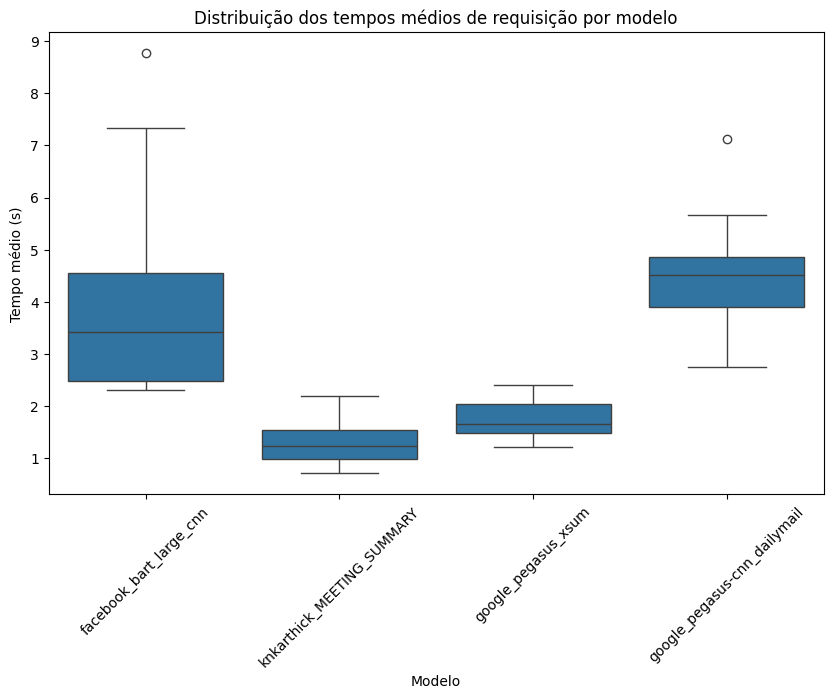

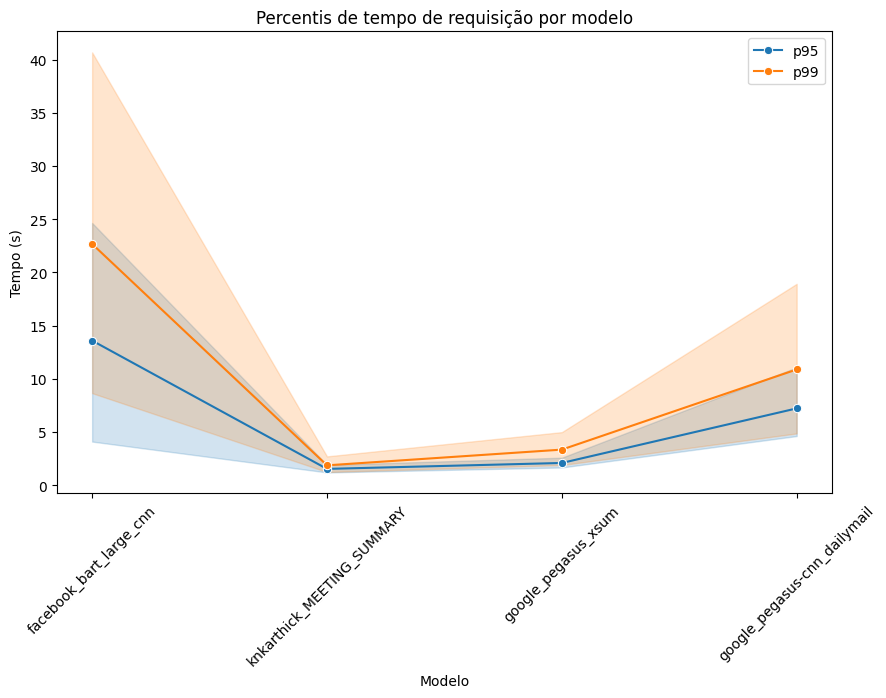

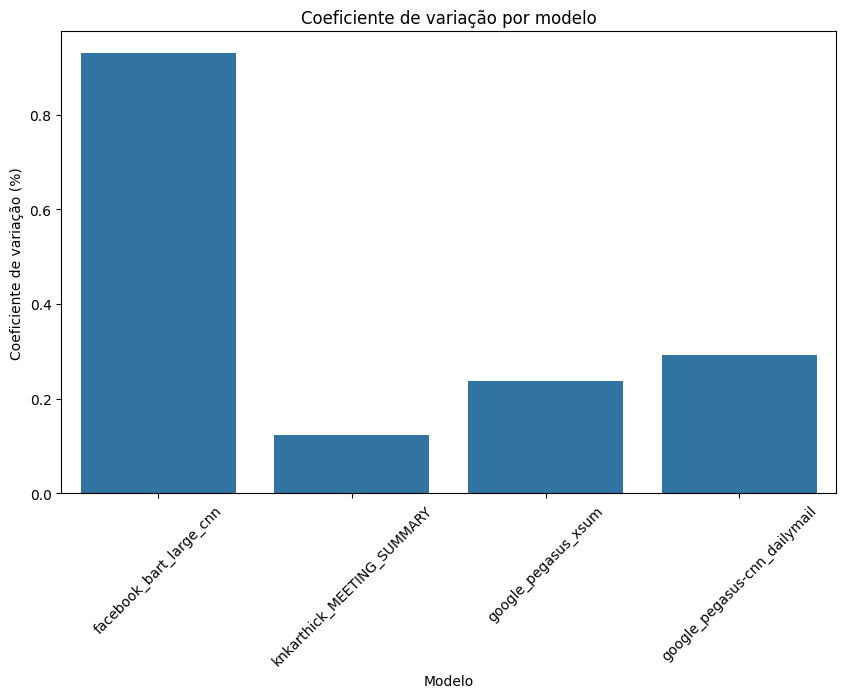

In [8]:
# Visualização gráfica dos resultados obtidos e armazenados em metricas_modelos_geral.csv ========================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# carregar o csv com as métricas
df = pd.read_csv("metricas_modelos_geral.csv")
df.head()

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="modelo", y="media_tempo_s", errorbar=None)
plt.xticks(rotation=45)
plt.title("Tempo médio de requisição por modelo")
plt.ylabel("Tempo médio (s)")
plt.xlabel("Modelo")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="modelo", y="media_tempo_s")
plt.xticks(rotation=45)
plt.title("Distribuição dos tempos médios de requisição por modelo")
plt.ylabel("Tempo médio (s)")
plt.xlabel("Modelo")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="modelo", y="p95_s", marker="o", label="p95")
sns.lineplot(data=df, x="modelo", y="p99_s", marker="o", label="p99")
plt.xticks(rotation=45)
plt.title("Percentis de tempo de requisição por modelo")
plt.ylabel("Tempo (s)")
plt.xlabel("Modelo")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="modelo", y="coef_var_%", errorbar=None)
plt.xticks(rotation=45)
plt.title("Coeficiente de variação por modelo")
plt.ylabel("Coeficiente de variação (%)")
plt.xlabel("Modelo")
plt.show()